In [13]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle

from scipy.optimize import fsolve
from scipy.optimize import differential_evolution
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

from temperature_JFET import *

T_operating = 89

# cascode params
V_DD = 11.7     # Supply voltage [V]
R_L = 1.6e3     # Load resistor  [Ohm]
V_G2 = 4.5      # Bias voltage for Q2's gate [V]

# feedback params
R_f = 1e9
C_f = 400e-15

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V
print('ADC to V:',round(ADC_to_V,7))


def integrate_signal(R_f, C_f, input_signal, dt, decay=True):
    tau = R_f * C_f             
    offset = np.mean(input_signal[:int(len(input_signal)*0.2)]) 
    output_signal = np.zeros_like(input_signal)
    effective_signal = input_signal - offset  

    if decay:
        decay_factor = np.exp(-dt /tau)
    else: decay_factor = 1

    for i in range(1, len(input_signal)):
        input_contribution = (effective_signal[i] + effective_signal[i-1]) * dt / (2 * C_f)
        output_signal[i] = output_signal[i-1] * decay_factor + input_contribution
    
    return -output_signal 

ADC to V: 6.5e-06


In [2]:
MX11_data_sheet = {
    'I_DSS':30e-3, 
    'VTO':-4.2, 
    'g_m':5.6e-3, 
    'nominal_T':293.15,
    'leakage_current': 1e-12, 
    }

BF862_data_sheet = {
    'I_DSS':17e-3, 
    'VTO':-0.8, 
    'g_m':45e-3, 
    'nominal_T':298.15
    }


method = 'differential_evolution'

MX11_params = infer_jfet_params(I_DSS=MX11_data_sheet['I_DSS'],
                                VTO=MX11_data_sheet['VTO'],
                                g_m=MX11_data_sheet['g_m'],
                                T=MX11_data_sheet['nominal_T'],
                                method = method,
                                )

BF862_params = infer_jfet_params(I_DSS=BF862_data_sheet['I_DSS'],
                                VTO=BF862_data_sheet['VTO'],
                                g_m=BF862_data_sheet['g_m'],
                                T=BF862_data_sheet['nominal_T'],
                                method = method
                                )

MX11_jfet = JFET(W_L_ratio=MX11_params['W_L_ratio'],
                a=MX11_params['a'],
                N_d=MX11_params['N_d'])

BF862_jfet = JFET(W_L_ratio=BF862_params['W_L_ratio'],
                a=BF862_params['a'],
                N_d=BF862_params['N_d'])



mx11_ds_T = MX11_data_sheet['nominal_T']
mx11_ds_idss = MX11_data_sheet['I_DSS']

bf862_ds_T = BF862_data_sheet['nominal_T']
bf862_ds_idss = BF862_data_sheet['I_DSS']


I_dds_mx11 = MX11_jfet.I_d(V_ds=10., V_gs=0., T=mx11_ds_T)
I_dds_bf862 = BF862_jfet.I_d(V_ds=10., V_gs=0., T=bf862_ds_T)


print(f'* MX11 I_DSS @ {mx11_ds_T} K: \nnominal: {mx11_ds_idss} \ncomputed: {I_dds_mx11} \ndifference: {np.abs(mx11_ds_idss-I_dds_mx11)}\n')
print(f'* BF862 I_DSS @ {bf862_ds_T} K: \nnominal: {bf862_ds_idss} \ncomputed: {I_dds_bf862} \ndifference: {np.abs(bf862_ds_idss-I_dds_bf862)}\n')

* MX11 I_DSS @ 293.15 K: 
nominal: 0.03 
computed: 0.025491102985849636 
difference: 0.004508897014150363

* BF862 I_DSS @ 298.15 K: 
nominal: 0.017 
computed: 0.017145222089570766 
difference: 0.0001452220895707644



In [3]:
def preprocess_dataframe(df):

    # Conversion factor from ADC to Volts
    ADC_to_V = 0.13/(20e3)
    
    # Create lists to store processed data
    scans = []
    signal_V_list = []
    time_signal_ns_list = []
    waveform_V_list = []
    time_waveform_ns_list = []
    time_stamp_signal_list = []
    time_stamp_waveform_list = []
    
    # Process each row
    for idx, row in df.iterrows():
        scan = row['scan']
        scans.append(scan)
        
        # Process signal data
        signal = np.array(row['signal'])
        time_windowed_signal = np.array(row['time_signal'])
        
        # Calculate offset from first 20% of signal data
        offset_idx = int(len(signal) * 0.2)
        offset = np.mean(signal[:offset_idx])
        
        # Remove offset and convert from ADC to V
        processed_signal = (signal - offset) * ADC_to_V
        
        # Convert time to start from 0 and convert to ns
        time_start = time_windowed_signal[0]
        processed_time_signal = (time_windowed_signal - time_start)
        
        # Process waveform data
        waveform = np.array(row['waveform'])
        time_windowed_waveform = np.array(row['time_waveform'])
        
        # Calculate offset from first 10% of waveform data
        offset_idx_wf = int(len(waveform) * 0.1)
        offset_wf = np.mean(waveform[:offset_idx_wf])
        
        # Remove offset and convert from ADC to V
        processed_waveform = (waveform - offset_wf) * ADC_to_V
        
        # Convert time to start from 0 and convert to ns
        time_start_wf = time_windowed_waveform[0]
        processed_time_waveform = (time_windowed_waveform - time_start_wf)  
        
        # Store processed data in lists
        signal_V_list.append(processed_signal.tolist())
        time_signal_ns_list.append(processed_time_signal.tolist())
        waveform_V_list.append(processed_waveform.tolist())
        time_waveform_ns_list.append(processed_time_waveform.tolist())
        time_stamp_signal_list.append(row['time_stamp_signal'])
        time_stamp_waveform_list.append(row['time_stamp_waveform'])
    
    # Create a new DataFrame all at once
    processed_df = pd.DataFrame({
        'scan': scans,
        'time_stamp_signal': time_stamp_signal_list,
        'signal': signal_V_list,
        'time_signal': time_signal_ns_list,
        'time_stamp_waveform': time_stamp_waveform_list,
        'waveform': waveform_V_list,
        'time_waveform': time_waveform_ns_list,
    })
    
    return processed_df


def sigmoid(t, A, k, t0, B):
    return A / (1 + np.exp(-k * (t - t0))) + B


def sort_by_waveform_amplitude(processed_df):
    # Create a copy of the processed DataFrame
    sorted_df = processed_df.copy()
    
    # List to store the amplitude values
    amplitudes = []
    var_amplitudes = []
    
    # Fit sigmoid to each waveform and extract the amplitude
    for idx, row in processed_df.iterrows():
        waveform = np.array(row['waveform'])
        time = np.array(row['time_waveform'])
        
        try:
            # Initial parameter guesses
            # A: estimate from max-min of waveform
            # k: moderate steepness
            # t0: midpoint of time range
            # B: minimum value of waveform
            p0 = [
                np.max(waveform) - np.min(waveform),  # A: amplitude guess
                0.1,                                   # k: steepness guess
                np.median(time),                       # t0: midpoint guess
                np.min(waveform)                       # B: offset guess
            ]
            
            # Set bounds to help convergence
            bounds = (
                [0, 0, np.min(time), -np.inf],          # Lower bounds
                [np.inf, np.inf, np.max(time), np.inf]  # Upper bounds
            )
            
            # Perform the fit
            popt, pcov = curve_fit(sigmoid, time, waveform, p0=p0, bounds=bounds, maxfev=10000)
            
            # Extract the amplitude (parameter A)
            amplitude = popt[0]
            amplitude_var = pcov[0][0]
            
        except Exception as e:
            print(f"Fitting failed for scan {row['scan']}: {e}")
            # Assign a default amplitude if fitting fails
            amplitude = 0
            amplitude_var = 0
        
        amplitudes.append(amplitude)
        var_amplitudes.append(amplitude_var)
    
    # Add the amplitude and variance columns to the DataFrame
    sorted_df['waveform_amplitude'] = amplitudes
    sorted_df['waveform_amplitude_var'] = var_amplitudes
    
    # Sort the DataFrame by amplitude
    sorted_df = sorted_df.sort_values(by='waveform_amplitude')
    
    # Reset the index
    sorted_df = sorted_df.reset_index(drop=True)
    
    return sorted_df

In [ ]:
# crate a list of files names
data_path = '/Users/raffaelegaudio/JFET_model/energy_scans_pulser/'

signals = []
waveforms = []

for id in range(14):
    signal = data_path+'pulser_signal_p11_r006_'+str(id)+'.json' 
    signals.append(signal)

for id in range(14):
    waveform = data_path+'mean_pulser_wf_all_ICPC_p11_r006_'+str(id)+'.json' 
    waveforms.append(waveform)


# create dictionaries to store the data
signal_data = {}
waveform_data = {}

for i, file_path in enumerate(signals):
    with open(file_path, 'r') as file:
        signal_data[f'scan_{i}'] = json.load(file)

for i, file_path in enumerate(waveforms):
    with open(file_path, 'r') as file:
        waveform_data[f'scan_{i}'] = json.load(file)


# create a dataframe with all the data
df_data = []

for i in range(14):
    row_data = {
        'scan': i,
        'time_stamp_signal': signal_data[f'scan_{i}']['time_stamp'],
        'signal': signal_data[f'scan_{i}']['signal'],
        'time_signal': signal_data[f'scan_{i}']['time_windowed'],

    }

    row_data['time_stamp_waveform'] = waveform_data[f'scan_{i}']['time_stamp'] 
    row_data['waveform'] = waveform_data[f'scan_{i}']['signal']
    row_data['time_waveform'] = waveform_data[f'scan_{i}']['time_windowed']

    df_data.append(row_data)

# Create the DataFrame
df = pd.DataFrame(df_data)

# Voltage conversion and time rescaling-----------------------------------------------------------------
processed_df = preprocess_dataframe(df)

# Attenuation factors-----------------------------------------------------------------------------------
def ratio(attenaution_db):
    return 10**(-attenaution_db/20.0)

attenuations_db = np.array([52,42,38,35,32,28,26,24,23,21,20,19,18,17])
ratios = np.array([ratio(i) for i in attenuations_db])


# Sort by waveform amplitue and apply attenuation function
sorted_df = sort_by_waveform_amplitude(processed_df)
scaled_df = sorted_df.copy()

# Apply the scaling to each row
for i in range(len(ratios)):
    # Make sure i is in range of both the DataFrame and ratios array
    if i < len(scaled_df) and i < len(ratios):
        scaled_df.at[i, 'signal'] = [val * ratios[i] for val in scaled_df.at[i, 'signal']]


scaled_df.drop(scaled_df.tail(3).index,inplace = True) # drop the last 3 rows which are affected by saturation
scaled_df

/var/folders/0d/wr4vslms6rx70gkgwp1_dz400000gn/T/ipykernel_28788/1621788783.py:73: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-k * (t - t0))) + B


,scan,time_stamp_signal,signal,time_signal,time_stamp_waveform,waveform,time_waveform,waveform_amplitude,waveform_amplitude_var
0,12,1.716273e+09,"[4.315062048411276e-09, 3.696958565803581e-08,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[3.760714285713948e-05, 3.110714285713948e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.004638,1.512630e-11
1,1,1.716273e+09,"[2.6424179794069536e-07, -3.5533422514424417e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[7.707142857137115e-06, 1.2071428571371145e-06...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.014515,1.341216e-10
2,2,1.716273e+09,"[4.120732642532984e-08, -4.062282534129105e-08...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716273e+09,"[-3.8164285714286054e-05, -5.7664285714286054e...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.022909,3.253645e-10
3,8,1.716272e+09,"[3.6657959838365994e-07, -5.581256948365801e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.771071428571395e-05, 5.121071428571395e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.032431,6.397754e-10
4,5,1.716272e+09,"[-7.574683244446494e-07, -1.0437785225215877e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[5.4460714285713954e-05, 6.746071428571396e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.045656,1.416528e-09
5,13,1.716272e+09,"[-4.620886801066035e-07, 1.6080686067715828e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[1.5042857142862886e-05, 4.754285714286289e-05...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.072507,3.377835e-09
6,3,1.716272e+09,"[1.0843543790409398e-06, -1.847590937678603e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-1.8385714285718678e-05, -3.788571428571868e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.091233,5.529557e-09
7,7,1.716272e+09,"[2.6072058841550167e-07, 6.708428623276273e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716272e+09,"[-8.171428571427897e-06, -1.6714285714278958e-...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.114635,8.766474e-09
8,10,1.716271e+09,"[1.3476253681308756e-06, 4.27295848431496e-07,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[4.039285714286052e-06, -1.5460714285713948e-0...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.128655,1.036040e-08
9,9,1.716271e+09,"[1.7606980586735308e-06, 6.020718390996616e-07...","[0.0, 16.011436740525824, 32.02287348105892, 4...",1.716271e+09,"[5.065357142856738e-05, 6.365357142856738e-05,...","[0.0, 16.011436740525824, 32.02287348105892, 4...",0.161716,1.578049e-08


In [7]:
def plot_signal_and_waveform(df, scan_number, display_scan=False):

    row = df[df['scan'] == scan_number].iloc[0]
    
    signal = row['signal']
    time_windowed_signal = row['time_signal']
    time_stamp_signal = row['time_stamp_signal']

    waveform = row['waveform']
    time_windowed_waveform = row['time_waveform']
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    if display_scan:
        fig.suptitle(f'[Scan: {scan_number}, Timestamp: {time_stamp_signal}]' )
    else:
        fig.suptitle(f'[Timestamp: {time_stamp_signal}]' )

    if isinstance(signal, (list, np.ndarray)):
        axs[0].plot(time_windowed_signal, signal)
    else:
        axs[0].plot(signal)
    
    axs[0].set_title(f'Input Signal')
    axs[0].set_xlabel('Time [ns]')
    axs[0].set_ylabel('Voltage [V]')
    axs[0].set_ylim([-0.0035, 0.05])
    axs[0].grid(alpha=0.5)
    
    if isinstance(waveform, (list, np.ndarray)):
        axs[1].plot(time_windowed_waveform, waveform)
    else:
        # Adjust as needed based on your data structure
        axs[1].plot(waveform)
    
    axs[1].set_title(f'Mean Waveform')
    axs[1].set_xlabel('Time [ns]')
    axs[1].set_ylabel('Voltage [V]')
    axs[1].set_ylim([-0.015, 0.23])
    axs[1].grid(alpha=0.5)
    
    plt.tight_layout()

Gain : 5.52619204124274 +/- 9.904873591433208e-06


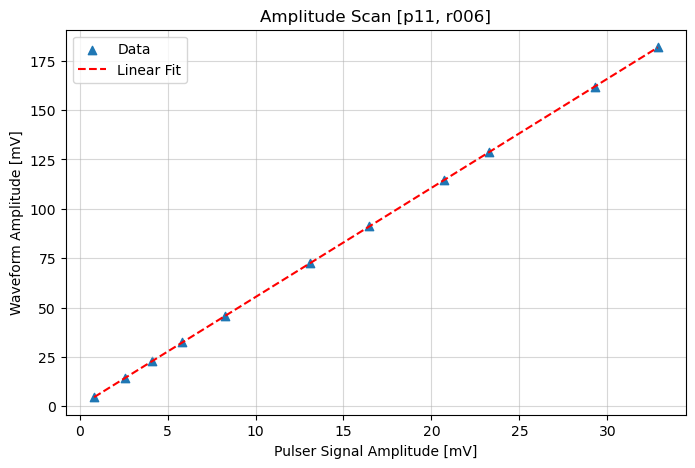

In [11]:
amplitude_signal = []
for signal in scaled_df['signal']:
    min_signal = np.mean(signal[:int(0.2 * len(signal))])  # Average over first 20%
    max_signal = np.max(signal)  # Maximum value
    amplitude_signal.append(max_signal - min_signal)

signal_amplitude=np.array(amplitude_signal)
waveform_amplitude=np.array([i for i in scaled_df['waveform_amplitude']])
waveform_amplitude_var=np.array([i for i in scaled_df['waveform_amplitude_var']])
waveform_amplitude_err = np.sqrt(waveform_amplitude_var)


def linear_fit(x, A, B):
    return A*x + B

popt, pcov = curve_fit(linear_fit,signal_amplitude,waveform_amplitude)
lin_gain = popt[0]



print(f'Gain : {lin_gain} +/- {pcov[0,0]}')

plt.figure(figsize=(8,5))
plt.scatter(signal_amplitude*1e3, waveform_amplitude*1e3,  marker='^', label='Data')
plt.plot(signal_amplitude*1e3,linear_fit(signal_amplitude, *popt)*1e3, 'r--', label='Linear Fit')
plt.title('Amplitude Scan [p11, r006]')
plt.xlabel('Pulser Signal Amplitude [mV]')
plt.ylabel('Waveform Amplitude [mV]')
plt.grid(alpha=0.5)
plt.legend();

In [14]:
with open('total_transfer_function_params.pkl', 'rb') as f:
    total_transfer_loaded = pickle.load(f)

In [16]:
def validation_test(idx, dc_bias, verbose=False):
    test_signal = np.array([i for i in scaled_df['signal'][idx]])
    test_signal_time = np.array([i*1e-9 for i in scaled_df['time_signal'][idx]])
    test_waveform = np.array([i for i in scaled_df['waveform'][idx]])
    test_waveform_time = np.array([i*1e-9 for i in scaled_df['time_waveform'][idx]])
    test_timestamp = scaled_df['time_stamp_signal'][idx]

    dt_signal = test_signal_time[1]-test_signal_time[0]

    dc_bias = dc_bias
    test_signal_biased = np.array([i+dc_bias for i in test_signal])

    test_signal_out = total_transfer_loaded(test_signal_biased)
    simulated_waveform = integrate_signal(R_f=1e9,C_f=400e-15,input_signal=test_signal_out,dt=dt_signal)


    simulated_waveform_amplitude = np.max(simulated_waveform)-np.mean(simulated_waveform[:int(len(simulated_waveform)*0.2)])
    test_waveform_amplitude = sorted_df['waveform_amplitude'][idx]

    conv_factor = test_waveform_amplitude/simulated_waveform_amplitude

    if verbose:
        print(f'Simulated Waveform Amplitude: {simulated_waveform_amplitude}')
        print(f'Real Waveform Amplitude: {test_waveform_amplitude}')
        print(f'Conversrion Factor: {conv_factor}\n')

    simulated_waveform_converted = np.array([i*conv_factor for i in simulated_waveform])


    plt.figure(figsize=(13,4))
    plt.suptitle(f'[Timestamp: {test_timestamp}]')

    plt.subplot(1,2,1)
    plt.title('Input Signal')
    plt.plot(test_signal_time*1e9,test_signal)
    plt.xlabel('Time [ns]')
    plt.ylabel('Voltage [V]')
    plt.grid(alpha=0.5)

    plt.subplot(1,2,2)
    plt.title('Output Signal')
    plt.plot(test_signal_time*1e9,simulated_waveform_converted, label='Simulated Waveform')
    plt.plot(test_waveform_time*1e9,test_waveform, label='Mean Waveform')
    plt.legend()
    plt.xlabel('Time [ns]')
    plt.ylabel('Voltage [V]')
    plt.grid(alpha=0.5)
    plt.tight_layout()

    return simulated_waveform_converted, simulated_waveform_amplitude, test_waveform_amplitude, conv_factor


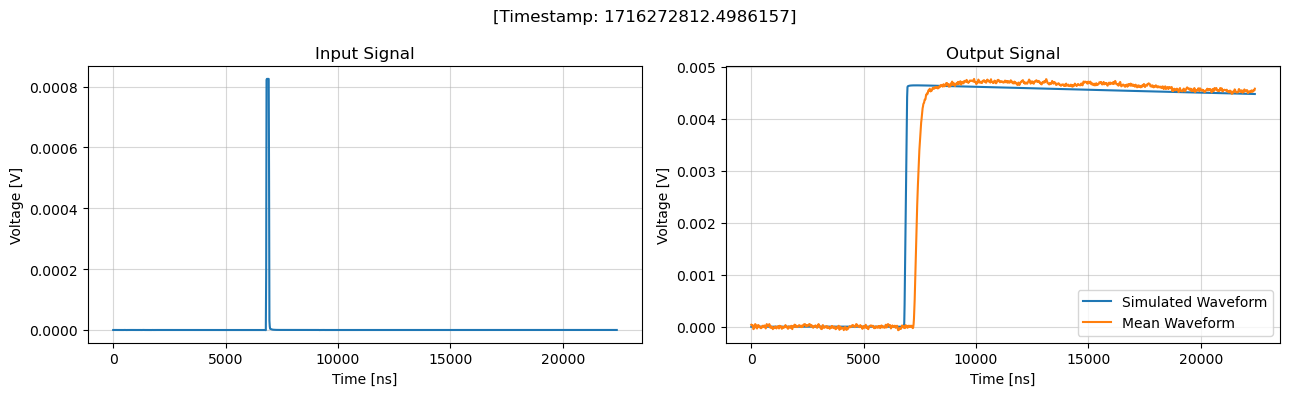

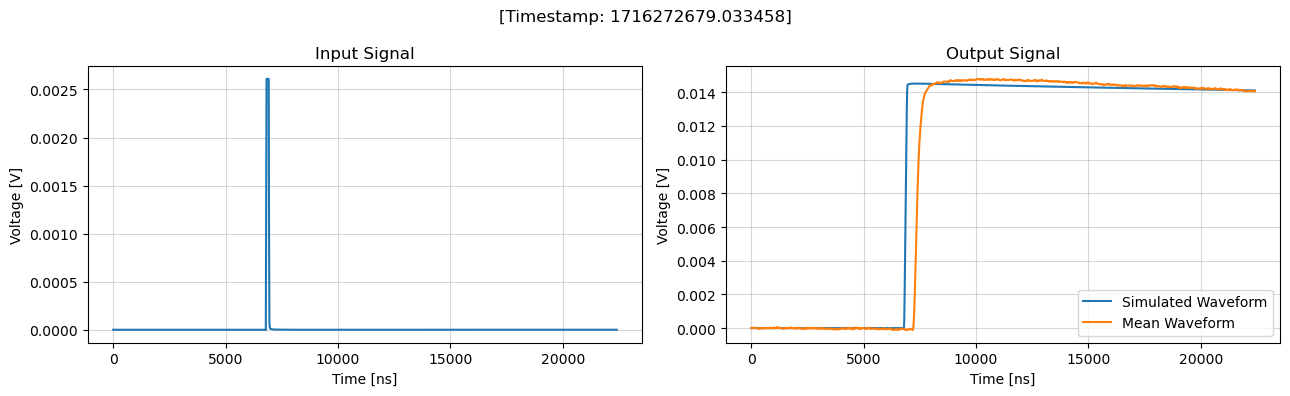

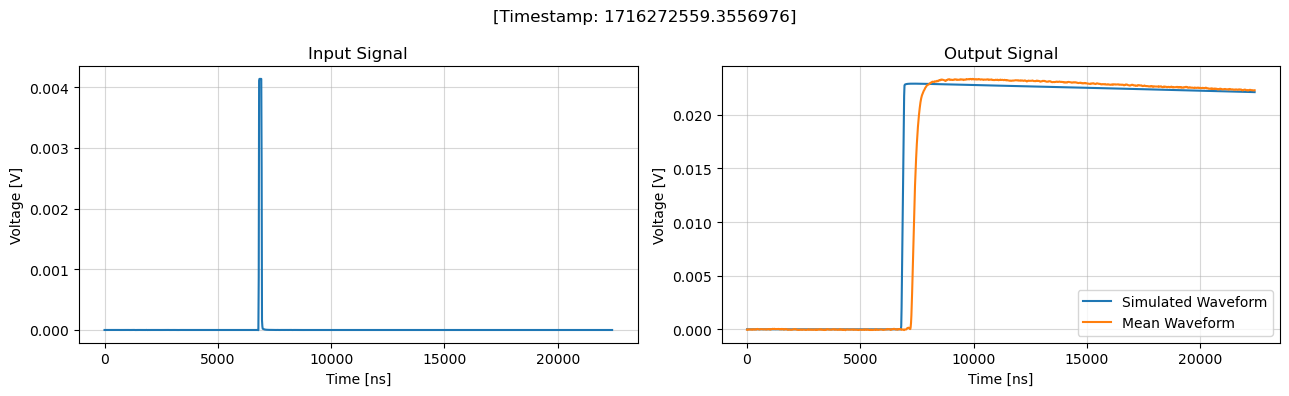

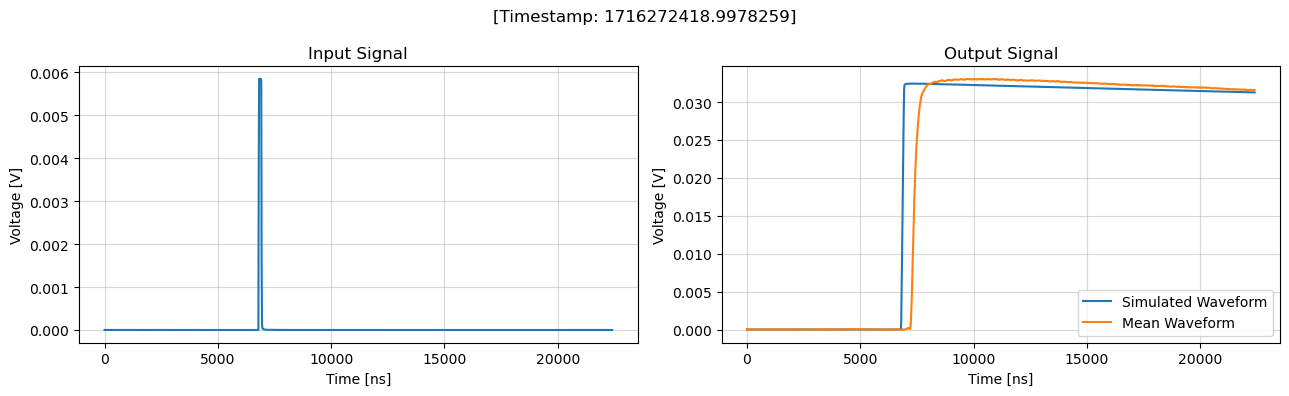

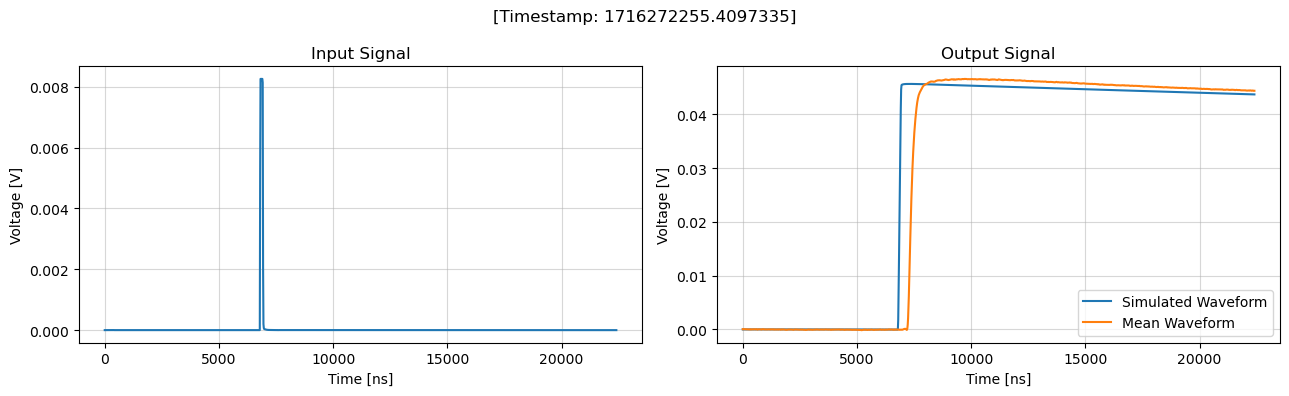

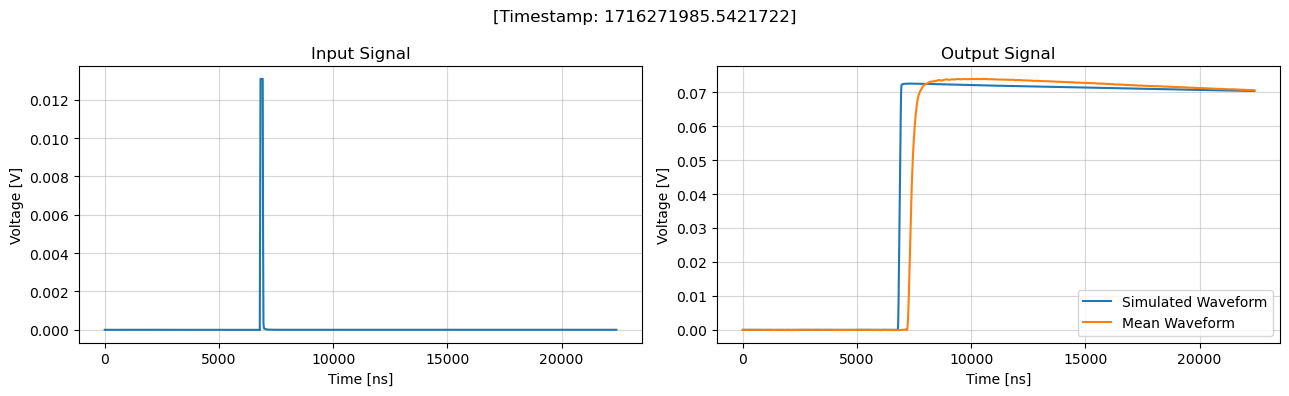

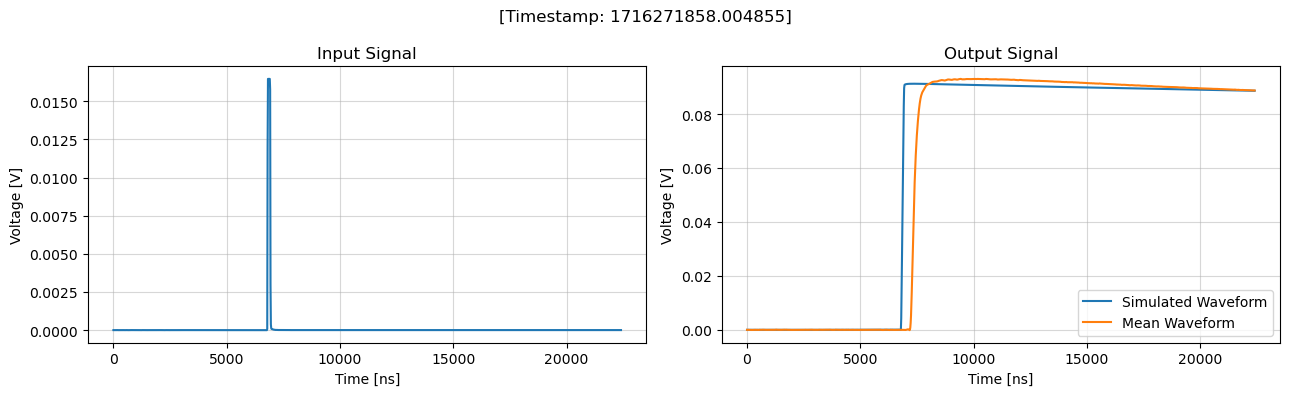

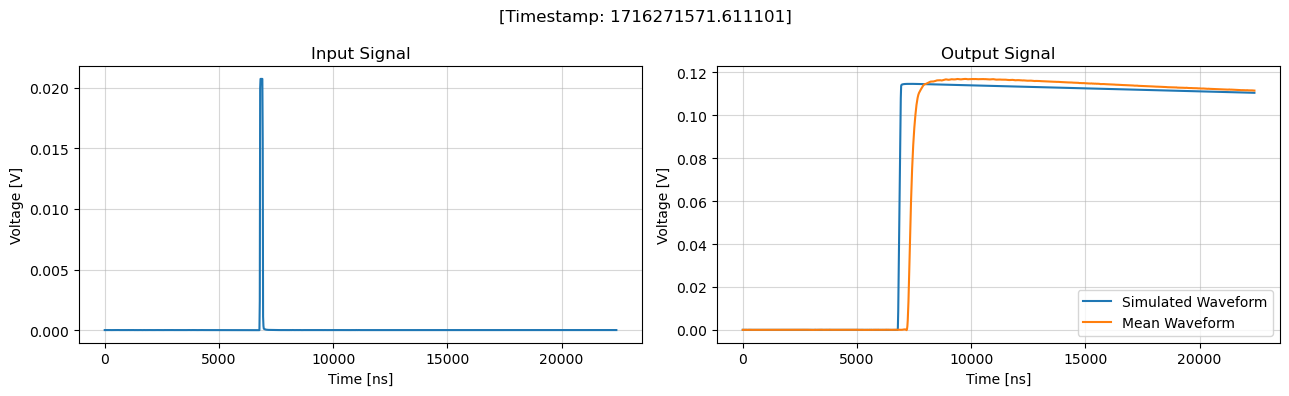

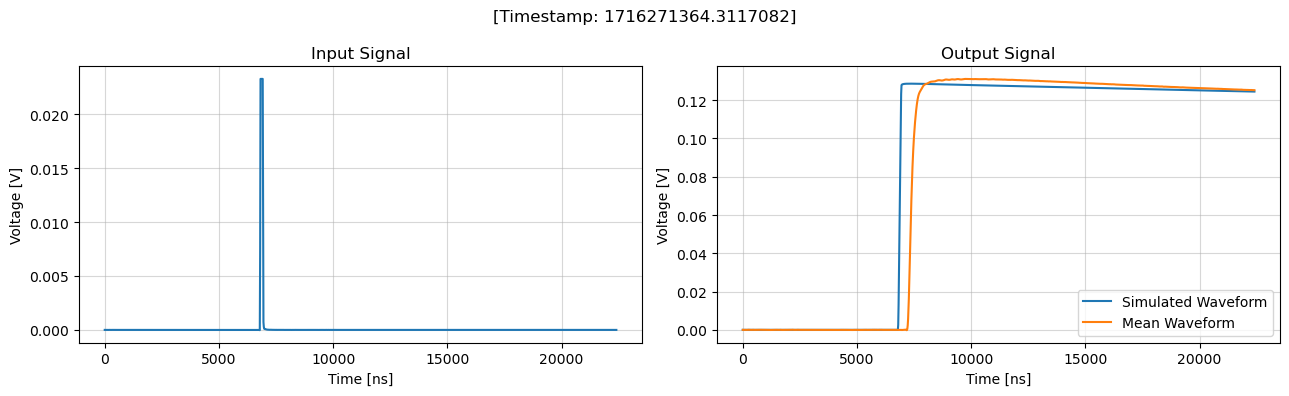

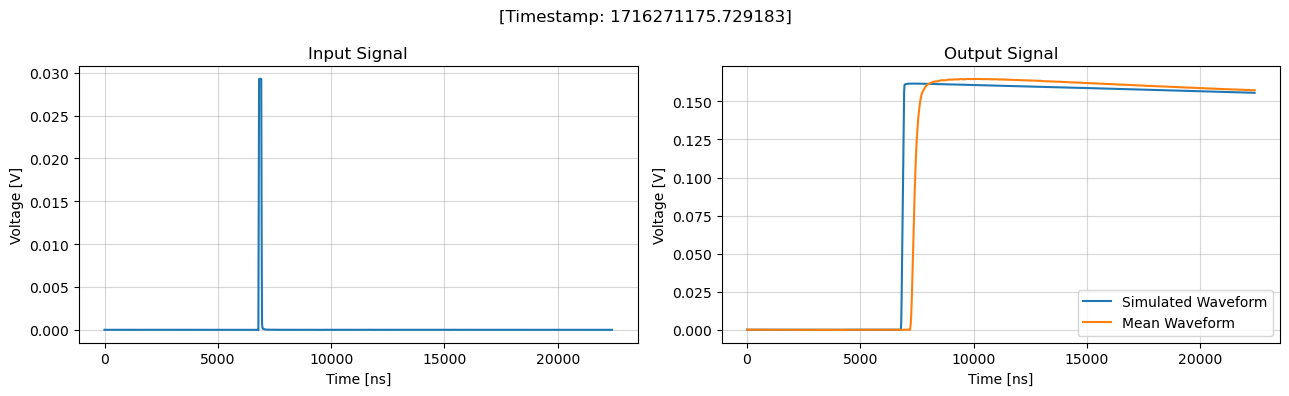

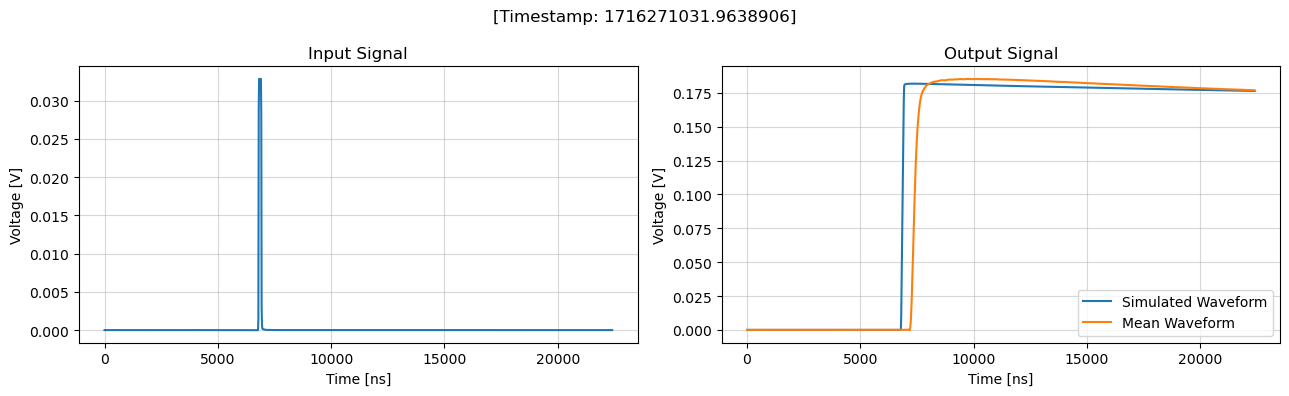

In [25]:
simulation_results = np.zeros((14,len(scaled_df['signal'][0])))
conv_factors = []
sim_ampls = []
wf_ampls = []

dc_bias=-3.52

for i in range(len(signal_amplitude)):
    result, sim_amp, wf_ampl, A = validation_test(i,dc_bias=dc_bias)
    simulation_results[i:]=result
    conv_factors.append(A)
    sim_ampls.append(sim_amp)
    wf_ampls.append(wf_ampl)

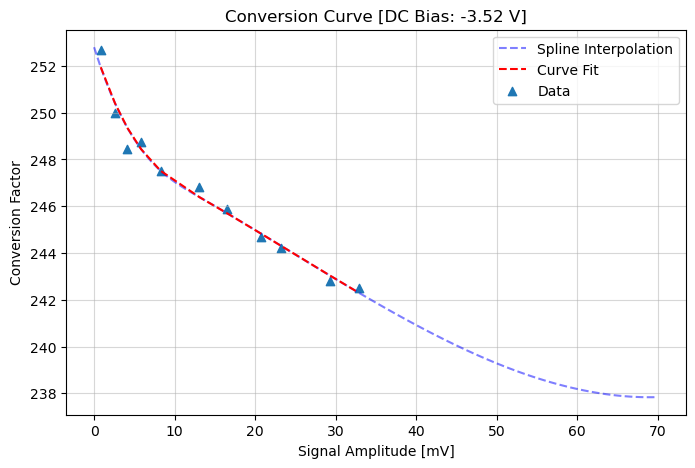

In [41]:
conversion_curve = UnivariateSpline(signal_amplitude,conv_factors, s=2)

test_amplitudes = np.linspace(0, 0.07, 100)  # Example test amplitudes

plt.figure(figsize=(8,5))
plt.title(f'Conversion Curve [DC Bias: {dc_bias} V]')
plt.plot(test_amplitudes*1e3, conversion_curve(test_amplitudes), 'b--', label='Spline Interpolation', alpha=0.5)
plt.plot(signal_amplitude*1e3,conversion_curve(signal_amplitude), 'r--', label='Curve Fit')
plt.scatter(signal_amplitude*1e3,conv_factors, marker='^', label='Data')

plt.xlabel('Signal Amplitude [mV]')
plt.ylabel('Conversion Factor')
plt.legend()
plt.grid(alpha=0.5)

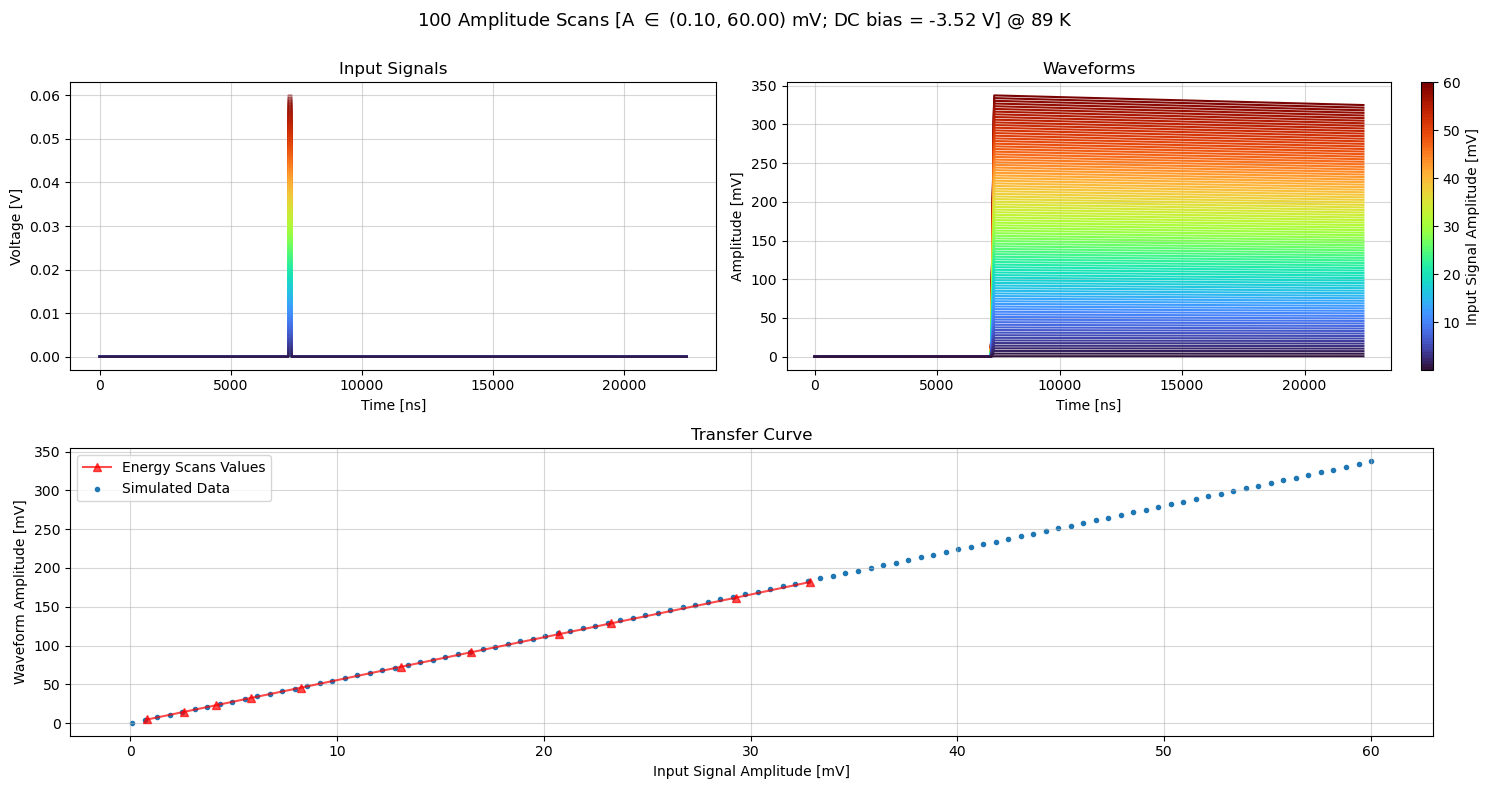

In [53]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


time = np.array([i * 1e-9 for i in scaled_df['time_signal'][0]])
dt = time[1] - time[0]

def delta_signal(time, amplitude, start, duration):
    signal = np.zeros_like(time)
    signal[start:start+duration] = amplitude
    return signal

# Create amplitude values (reverse order for color mapping consistency)
amplitudes = np.linspace(0.06, 0.0001, 100)
dc_bias = -3.52
toy_signals = []
sim_waveforms = []

for a in amplitudes:
    input_signal = delta_signal(time, 1, 450, 8)
    signal = input_signal * a + dc_bias
    output = total_transfer_loaded(signal)
    integrated_signal = integrate_signal(C_f=400e-15, R_f=1e9, input_signal=output, dt=dt, decay=True)
    conversion_factor = conversion_curve(a)
    final_out = np.array([i * conversion_factor for i in integrated_signal])
    toy_signals.append(signal)
    sim_waveforms.append(final_out)

sim_amplitudes_converted = np.array([np.max(i) for i in sim_waveforms])


cmap_name = "turbo"


norm = plt.Normalize(min(amplitudes)*1e3, max(amplitudes)*1e3)
cmap = cm.get_cmap(cmap_name, len(amplitudes)).reversed()
cmap_2 = cmap.reversed()

# Create the figure and a flexible grid layout
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    f'100 Amplitude Scans [A $\in$ ({min(amplitudes)*1e3:.2f}, {max(amplitudes)*1e3:.2f}) mV; DC bias = {np.round(dc_bias,3)} V] @ 89 K',
    fontsize=13)

gs = fig.add_gridspec(2, 2, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input Signals')
for idx, signal in enumerate(toy_signals):
    color = cmap(idx)
    ax1.plot(time * 1e9, signal-dc_bias, color=color, alpha=0.5)
ax1.grid(alpha=0.5)
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Voltage [V]')

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Waveforms')
for idx, (a, waveform) in enumerate(zip(amplitudes, sim_waveforms)):
    color = cmap(idx)
    ax2.plot(time * 1e9, waveform*1e3, color=color)
ax2.grid(alpha=0.5)
ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Amplitude [mV]')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap_2, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label('Input Signal Amplitude [mV]')

ax3 = fig.add_subplot(gs[1, :])
ax3.set_title('Transfer Curve')
ax3.plot(signal_amplitude*1e3, waveform_amplitude*1e3, '^-', color='red', label='Energy Scans Values', alpha=0.7)
for i, a in enumerate(amplitudes):
    if i == 0:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue', label='Simulated Data')
    else:
        ax3.scatter(a*1e3, np.max(sim_waveforms[i])*1e3, marker='.', color='tab:blue')
ax3.grid(alpha=0.5)
ax3.set_xlabel('Input Signal Amplitude [mV]')
ax3.set_ylabel('Waveform Amplitude [mV]')
ax3.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

